<a href="https://colab.research.google.com/github/iamsommyajain/Hate-Speech-Detection/blob/main/Hate_Speech_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download mrmorj/hate-speech-and-offensive-language-dataset

Dataset URL: https://www.kaggle.com/datasets/mrmorj/hate-speech-and-offensive-language-dataset
License(s): CC0-1.0
hate-speech-and-offensive-language-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/hate-speech-and-offensive-language-dataset.zip')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import pandas as pd
import spacy
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
df=pd.read_csv('/content/labeled_data.csv')

In [6]:
df.shape

(24783, 7)

In [7]:
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [8]:
df.columns

Index(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither',
       'class', 'tweet'],
      dtype='object')

In [9]:
df.drop(columns = ['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither'],inplace=True)

In [10]:
df.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [11]:
df.isna().sum()

,0
class,0
tweet,0


In [12]:
df['tweet'].iloc[0]

"!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out..."

In [13]:
df['processed_tweet'] = df['tweet'].str.replace(r'[^a-zA-Z]',' ',regex=True)

In [14]:
df['processed_tweet'].iloc[0]

'    RT  mayasolovely  As a woman you shouldn t complain about cleaning up your house   amp  as a man you should always take the trash out   '

In [15]:
df['processed_tweet'] = df['processed_tweet'].str.replace(r'[\s]+',' ',regex=True)

In [16]:
df['processed_tweet'].iloc[0]

' RT mayasolovely As a woman you shouldn t complain about cleaning up your house amp as a man you should always take the trash out '

In [17]:
df.head()

,class,tweet,processed_tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...,RT mayasolovely As a woman you shouldn t comp...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,RT mleew boy dats cold tyga dwn bad for cuffi...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,RT UrKindOfBrand Dawg RT sbaby life You ever ...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,RT C G Anderson viva based she look like a tr...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,RT ShenikaRoberts The shit you hear about me ...


In [18]:
df.drop(columns=['tweet'],inplace=True)

In [19]:
nlp = spacy.load('en_core_web_sm')

In [20]:
def lemmatization(text) :
  doc = nlp(text)
  lemmaList = [word.lemma_ for word in doc]
  return ' '.join(lemmaList)

In [21]:
df['lemma_tweet'] = df['processed_tweet'].apply(lemmatization)

In [22]:
df.head()

,class,processed_tweet,lemma_tweet
0,2,RT mayasolovely As a woman you shouldn t comp...,RT mayasolovely as a woman you shouldn t com...
1,1,RT mleew boy dats cold tyga dwn bad for cuffi...,RT mleew boy dat cold tyga dwn bad for cuffi...
2,1,RT UrKindOfBrand Dawg RT sbaby life You ever ...,RT UrKindOfBrand Dawg RT sbaby life you ever...
3,1,RT C G Anderson viva based she look like a tr...,RT C G Anderson viva base she look like a tr...
4,1,RT ShenikaRoberts The shit you hear about me ...,RT ShenikaRoberts the shit you hear about I ...


In [23]:
def remove_stopwords(text) :
  doc = nlp(text)
  no_stopwords_list = [word.text for word in doc if not word.is_stop]
  return " ".join(no_stopwords_list)

In [24]:
df['final_tweet'] = df['lemma_tweet'].apply(remove_stopwords)

In [25]:
df['lemma_tweet'].iloc[67]

'  Allyhaaaaa Lemmie eat a Oreo amp do these dish one oreo lol'

In [26]:
df['final_tweet'].iloc[67]

'   Allyhaaaaa Lemmie eat Oreo amp dish oreo lol'

In [27]:
vocab_size = 10000
one_hot_representation = [one_hot(words,vocab_size) for words in df['final_tweet']]

In [28]:
for i in range (4) :
  print(df['final_tweet'].iloc[i])

   RT mayasolovely woman shouldn t complain clean house amp man trash
   RT mleew boy dat cold tyga dwn bad cuffin dat hoe st place
   RT UrKindOfBrand Dawg RT sbaby life fuck bitch start cry confuse shit
   RT C G Anderson viva base look like tranny


In [29]:
for i in range (4) :
  print(one_hot_representation[i])

[6878, 6092, 8798, 7144, 2339, 7156, 2014, 2539, 2303, 5769, 4482]
[6878, 9817, 7670, 2186, 7979, 3301, 4558, 1224, 244, 2186, 8803, 737, 8942]
[6878, 7126, 5728, 6878, 9149, 8708, 1449, 6360, 2415, 9009, 1373, 3944]
[6878, 3478, 4884, 9116, 4574, 8583, 1153, 3040, 6844]


In [30]:
sentence_length = 20
embedded_tweet = pad_sequences(one_hot_representation, padding = 'pre', maxlen = sentence_length)

In [31]:
for i in range(4) :
  print(embedded_tweet[i])

[   0    0    0    0    0    0    0    0    0 6878 6092 8798 7144 2339
 7156 2014 2539 2303 5769 4482]
[   0    0    0    0    0    0    0 6878 9817 7670 2186 7979 3301 4558
 1224  244 2186 8803  737 8942]
[   0    0    0    0    0    0    0    0 6878 7126 5728 6878 9149 8708
 1449 6360 2415 9009 1373 3944]
[   0    0    0    0    0    0    0    0    0    0    0 6878 3478 4884
 9116 4574 8583 1153 3040 6844]


In [32]:
X = np.array(embedded_tweet)
y = np.array(df['class'])

In [33]:
df['class'].value_counts()

,count
class,
1,19190
2,4163
0,1430


In [34]:
smote = SMOTE(sampling_strategy='minority')
X, y = smote.fit_resample(X, y)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
X_train.shape, X_test.shape

((34034, 20), (8509, 20))

In [37]:
dimension = 50

model = keras.Sequential([
    #embedding layer
    keras.layers.Embedding(vocab_size,dimension, input_length=sentence_length),
    #LSTM Layers (Stacked)
    keras.layers.LSTM(100,return_sequences=True),
    keras.layers.LSTM(50,return_sequences=True),
    keras.layers.LSTM(32),
    #output layer
    keras.layers.Dense(3,activation='softmax')
])

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [38]:
model.fit(X_train,y_train,epochs=10,validation_data=(X_test,y_test),batch_size=32)

Epoch 1/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.7846 - loss: 0.4991 - val_accuracy: 0.9237 - val_loss: 0.2321
Epoch 2/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9436 - loss: 0.1750 - val_accuracy: 0.9222 - val_loss: 0.2399
Epoch 3/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.9606 - loss: 0.1257 - val_accuracy: 0.9174 - val_loss: 0.2592
Epoch 4/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.9704 - loss: 0.0951 - val_accuracy: 0.9089 - val_loss: 0.3312
Epoch 5/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.9772 - loss: 0.0739 - val_accuracy: 0.9075 - val_loss: 0.3797
Epoch 6/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.9840 - loss: 0.0505 - val_accuracy: 0.8975 - val_loss: 0.4259
Epoch 7/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.9906 - loss: 0.0322 - val_accuracy: 0.8972 - val_loss: 0.5097
Epoch 8/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.9917 -

In [39]:
loss, accuracy = model.evaluate(X_test,y_test)
print(f'Model Accuracy :{accuracy*100}')

266/266 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9042 - loss: 0.5332
Model Accuracy :89.84604477882385


In [40]:
pred = np.argmax(model.predict(X_test),axis=-1)

266/266 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


In [41]:
y_test[:5]

array([1, 1, 0, 1, 2])

In [42]:
pred[:5]

array([1, 1, 0, 1, 2])

In [43]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      3812
           1       0.92      0.90      0.91      3807
           2       0.74      0.80      0.77       890

    accuracy                           0.90      8509
   macro avg       0.86      0.87      0.87      8509
weighted avg       0.90      0.90      0.90      8509



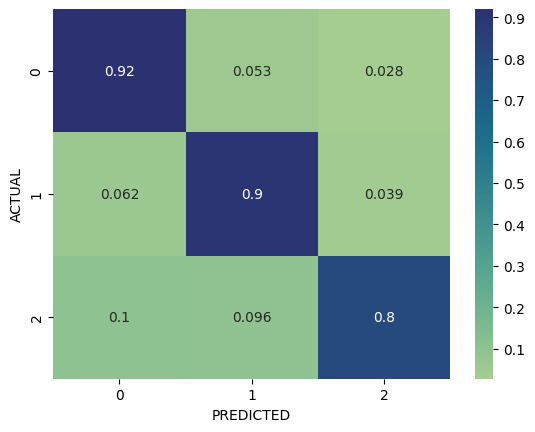

In [44]:
cf = confusion_matrix(y_test,pred,normalize='true')
sns.heatmap(cf, annot = True, cmap ='crest')
plt.xlabel('PREDICTED')
plt.ylabel('ACTUAL')
plt.show()

In [45]:
model.save('hate_speech_model.h5')

In [46]:
!pip install gradio

In [47]:
import gradio as gr
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load trained model
model = tf.keras.models.load_model('/content/hate_speech_model.h5')  # Update path if needed

# Define preprocessing function
vocab_size = 10000
sentence_length = 20

def preprocess_text(text):
    processed_text = text.lower()  # Convert to lowercase
    processed_text = ''.join([char if char.isalnum() or char.isspace() else ' ' for char in processed_text])  # Remove special chars
    processed_text = ' '.join(processed_text.split())  # Remove extra spaces
    one_hot_rep = one_hot(processed_text, vocab_size)
    embedded_tweet = pad_sequences([one_hot_rep], padding='pre', maxlen=sentence_length)
    return embedded_tweet

# Define prediction function
label_map = {0: "Hate Speech", 1: "Offensive Language", 2: "Neither"}

def predict_hate_speech(text):
    processed_input = preprocess_text(text)
    prediction = model.predict(processed_input)
    predicted_class = np.argmax(prediction, axis=-1)[0]
    return f"Prediction: {label_map[predicted_class]}"

# Gradio Interface
interface = gr.Interface(
    fn=predict_hate_speech,
    inputs=gr.Textbox(placeholder="Enter text to analyze..."),
    outputs="text",
    title="Hate Speech Detection",
    description="Enter a sentence, and the model will classify it as Hate Speech, Offensive Language, or Neither."
)

# Launch app
interface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5cdc7805d4ccb7e9cf.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
